# Parkings forecasting with Prophet

## Initial setup

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

from utils import get_forecast_total_sum, cross_validate

In [87]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [88]:
df = pd.read_csv("../data/parkings_small.csv") # all zones
df = df[df["zone_id"] == 1] # zone1
df['time_start'] = pd.to_datetime(df['time_start'], format="ISO8601")
df['time_end'] = pd.to_datetime(df['time_end'], format="ISO8601")

In [89]:
rain_df = pd.read_csv('../data/artukainen_rain.csv')
rain_df['timestamp'] = pd.to_datetime(rain_df['timestamp'])
rain_df = rain_df.rename(columns={"timestamp": "ds", "value": "rain"})

In [90]:
temp_df = pd.read_csv('../data/artukainen_temperature.csv')
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
temp_df = temp_df.rename(columns={"timestamp": "ds", "value": "temp"})

In [91]:
# Create an Hourly Time Series for Parking Occupancy
# Generate hourly timestamps for each hour eg 0, 1, 2
hourly_index = pd.date_range(start=df['time_start'].min().floor('h'),
                             end=df['time_end'].max().ceil('h'),
                             freq='h')

# Initialize an empty DataFrame for hourly occupancy counts
hourly_parking = pd.DataFrame({'ds': hourly_index})

# Count active parkings in each hour
def count_active_parkings(timestamp):
    return ((df['time_start'] <= timestamp) & (df['time_end'] > timestamp)).sum()
    # time stamp is between start and end time of parking

hourly_parking['y'] = hourly_parking['ds'].apply(count_active_parkings)
hourly_parking['ds'] = hourly_parking['ds'].dt.tz_localize(None)
hourly_parking.head()

,ds,y
0,2024-05-07 13:00:00,0
1,2024-05-07 14:00:00,0
2,2024-05-07 15:00:00,0
3,2024-05-07 16:00:00,0
4,2024-05-07 17:00:00,0


In [92]:
# Merge rain data
hourly_parking = pd.merge(hourly_parking, rain_df, on='ds', how='left')
# Merge temperature data
hourly_parking = pd.merge(hourly_parking, temp_df, on='ds', how='left')
hourly_parking.tail()

,ds,y,rain,temp
6618,2025-02-07 07:00:00,2,0.0,-0.4
6619,2025-02-07 08:00:00,2,0.0,0.0
6620,2025-02-07 09:00:00,2,0.0,0.2
6621,2025-02-07 10:00:00,2,0.0,0.3
6622,2025-02-07 11:00:00,0,0.0,0.2


In [93]:
# Function to create a model and forecast
def create_model_and_forecast(df, interval_width=0.80, rain=None, temp=None):
    m = Prophet(interval_width=interval_width)
    m.add_country_holidays(country_name='FI')
    if rain:
        m.add_regressor('rain')
    if temp:
        m.add_regressor('temp')
    m.fit(df)

    days = 30
    forecast_days = 24*days
    future = m.make_future_dataframe(periods=forecast_days, freq='h')
    last_date = future['ds'].max()
    start_date = last_date - pd.Timedelta(days=days-1)
    if rain:
        future = pd.merge(future, rain_df, on='ds', how='left')
        future.loc[future['ds'] >= start_date, 'rain'] = rain
    if temp:
        future = pd.merge(future, temp_df, on='ds', how='left')
        future.loc[future['ds'] >= start_date, 'temp'] = temp

    forecast = m.predict(future)
    forecast['yhat'] = np.round(np.maximum(forecast['yhat'], 0))
    forecast['yhat_lower'] = np.round(np.maximum(forecast['yhat_lower'], 0))
    forecast['yhat_upper'] = np.round(np.maximum(forecast['yhat_upper'], 0))
    return m, forecast

In [94]:
baseline_model, baseline_forecast = create_model_and_forecast(hourly_parking, interval_width=0.99, rain=None, temp=None)
rain_model, rain_forecast = create_model_and_forecast(hourly_parking, interval_width=0.99, rain=3.0, temp=None)
temp_model_minus20, temp_forecast_minus20 = create_model_and_forecast(hourly_parking, interval_width=0.99, rain=None, temp=-20)
temp_model_minus10, temp_forecast_minus10 = create_model_and_forecast(hourly_parking, interval_width=0.99, rain=None, temp=-10)
temp_model_0, temp_forecast_0 = create_model_and_forecast(hourly_parking, interval_width=0.99, rain=None, temp=0)
temp_model_plus10, temp_forecast_plus10 = create_model_and_forecast(hourly_parking, interval_width=0.99, rain=None, temp=10)
temp_model_plus20, temp_forecast_plus20 = create_model_and_forecast(hourly_parking, interval_width=0.99, rain=None, temp=20)

14:00:45 - cmdstanpy - INFO - Chain [1] start processing
14:00:46 - cmdstanpy - INFO - Chain [1] done processing
14:00:47 - cmdstanpy - INFO - Chain [1] start processing
14:00:47 - cmdstanpy - INFO - Chain [1] done processing
14:00:48 - cmdstanpy - INFO - Chain [1] start processing
14:00:49 - cmdstanpy - INFO - Chain [1] done processing
14:00:49 - cmdstanpy - INFO - Chain [1] start processing
14:00:50 - cmdstanpy - INFO - Chain [1] done processing
14:00:51 - cmdstanpy - INFO - Chain [1] start processing
14:00:52 - cmdstanpy - INFO - Chain [1] done processing
14:00:52 - cmdstanpy - INFO - Chain [1] start processing
14:00:53 - cmdstanpy - INFO - Chain [1] done processing
14:00:54 - cmdstanpy - INFO - Chain [1] start processing
14:00:54 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
# total parkings in forecast
start_date = hourly_parking['ds'].max()
end_date = start_date + pd.Timedelta(days=30)
print(f'Forecast period: {start_date} - {end_date}')

base_total = get_forecast_total_sum(baseline_forecast, start_date, end_date)
rain_total = get_forecast_total_sum(rain_forecast, start_date, end_date)
temp_minus20_total = get_forecast_total_sum(temp_forecast_minus20, start_date, end_date)
temp_minus10_total = get_forecast_total_sum(temp_forecast_minus10, start_date, end_date)
temp_0_total = get_forecast_total_sum(temp_forecast_0, start_date, end_date)
temp_plus10_total = get_forecast_total_sum(temp_forecast_plus10, start_date, end_date)
temp_plus20_total = get_forecast_total_sum(temp_forecast_plus20, start_date, end_date)
print(f'Baseline forecast cars: {base_total}')
print(f'Rain forecast cars: {rain_total}. Diff to baseline: {rain_total-base_total}')
print(f'Temp -20 forecast cars: {temp_minus20_total}. Diff to baseline: {temp_minus20_total-base_total}')
print(f'Temp -10 forecast cars: {temp_minus10_total}. Diff to baseline: {temp_minus10_total-base_total}')
print(f'Temp 0 forecast cars: {temp_0_total}. Diff to baseline: {temp_0_total-base_total}')
print(f'Temp +10 forecast cars: {temp_plus10_total}. Diff to baseline: {temp_plus10_total-base_total}')
print(f'Temp +20 forecast cars: {temp_plus20_total}. Diff to baseline: {temp_plus20_total-base_total}')

Forecast period: 2025-02-07 11:00:00 - 2025-03-09 11:00:00
Baseline forecast cars: 96892.0
Rain forecast cars: 92316.0. Diff to baseline: -4576.0
Temp -20 forecast cars: 117506.0. Diff to baseline: 20614.0
Temp -10 forecast cars: 107682.0. Diff to baseline: 10790.0
Temp 0 forecast cars: 96892.0. Diff to baseline: 0.0
Temp +10 forecast cars: 88783.0. Diff to baseline: -8109.0
Temp +20 forecast cars: 79933.0. Diff to baseline: -16959.0


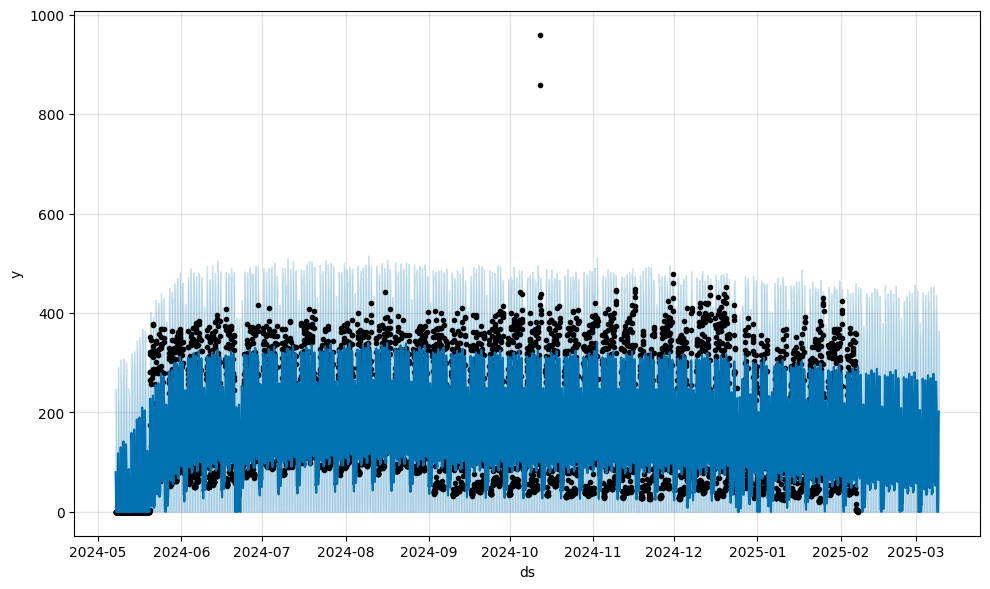

In [96]:
# Plot Forecast
fig = baseline_model.plot(baseline_forecast)
plt.show()

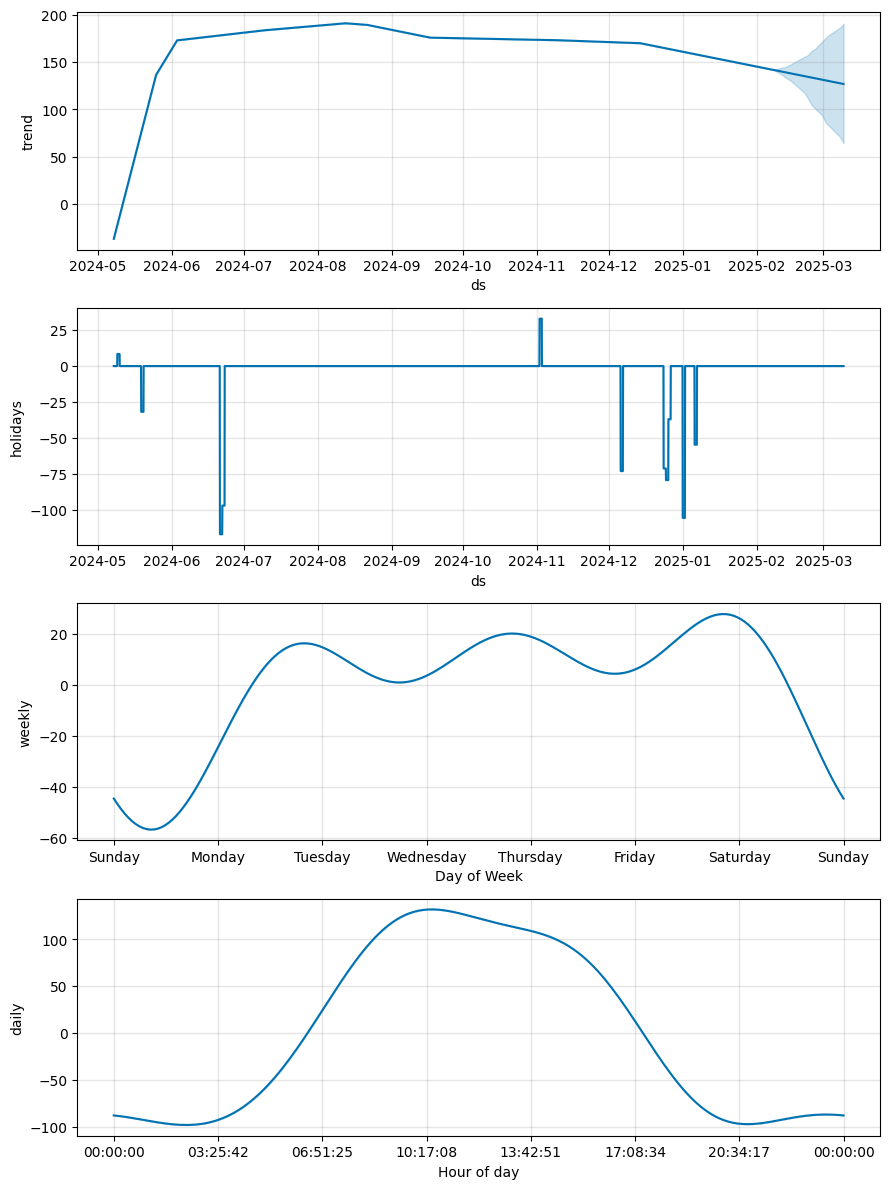

In [97]:
# Plot Trend and Seasonality Components
fig2 = baseline_model.plot_components(baseline_forecast)
plt.show()

In [98]:
base_cv = cross_validate(baseline_model, initial='180 days', period='15 days', horizon='30 days')
base_cv_p = performance_metrics(base_cv)
base_cv_p.head()

  0%|          | 0/5 [00:00<?, ?it/s]

14:00:55 - cmdstanpy - INFO - Chain [1] start processing
14:00:56 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:02,  1.83it/s]14:00:56 - cmdstanpy - INFO - Chain [1] start processing
14:00:56 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:01<00:01,  1.68it/s]14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:01,  1.59it/s]14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:58 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:02<00:00,  1.61it/s]14:00:58 - cmdstanpy - INFO - Chain [1] start processing
14:00:58 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days 00:00:00,5332.492039,73.023914,56.598412,0.390786,0.474578,0.947222
1,3 days 01:00:00,5270.573586,72.598716,56.381347,0.387474,0.472246,0.947222
2,3 days 02:00:00,5179.482617,71.968622,55.873832,0.380197,0.469322,0.950000
3,3 days 03:00:00,5070.236926,71.205596,55.197293,0.369430,0.466237,0.952778
4,3 days 04:00:00,5028.395709,70.911182,55.223686,0.357641,0.465612,0.955556


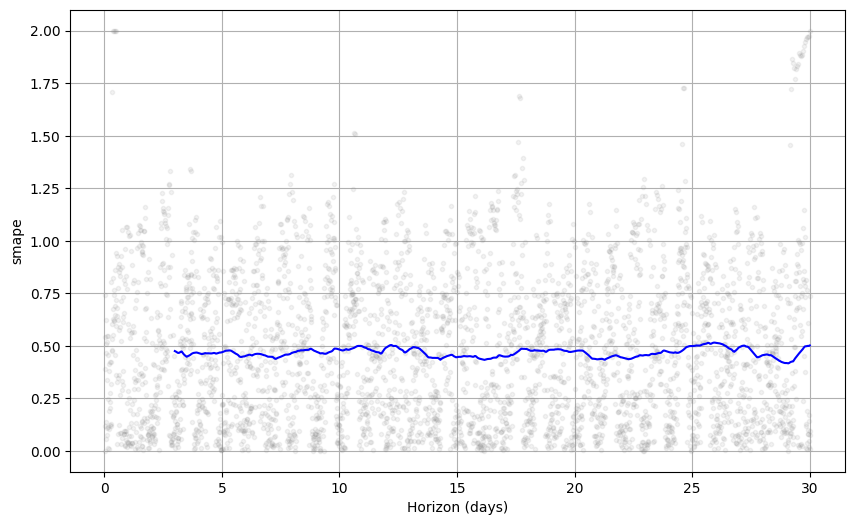

In [99]:
fig = plot_cross_validation_metric(base_cv, metric='smape')

In [100]:
rain_cv = cross_validate(rain_model, initial='180 days', period='15 days', horizon='30 days')
rain_cv_p = performance_metrics(rain_cv)
rain_cv_p.head()

  0%|          | 0/5 [00:00<?, ?it/s]

14:00:59 - cmdstanpy - INFO - Chain [1] start processing
14:00:59 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:02,  1.88it/s]14:00:59 - cmdstanpy - INFO - Chain [1] start processing
14:01:00 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:01<00:01,  1.68it/s]14:01:00 - cmdstanpy - INFO - Chain [1] start processing
14:01:00 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:01,  1.66it/s]14:01:01 - cmdstanpy - INFO - Chain [1] start processing
14:01:01 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:02<00:00,  1.67it/s]14:01:01 - cmdstanpy - INFO - Chain [1] start processing
14:01:02 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days 00:00:00,5338.926577,73.067959,56.705969,0.393126,0.475513,0.944444
1,3 days 01:00:00,5276.074959,72.636595,56.482510,0.387999,0.473157,0.944444
2,3 days 02:00:00,5183.865503,71.999066,55.968197,0.382500,0.470207,0.947222
3,3 days 03:00:00,5073.693984,71.229867,55.283796,0.367510,0.467090,0.950000
4,3 days 04:00:00,5031.029943,70.929754,55.302555,0.357034,0.466431,0.952778
